In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
#import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from numpy import absolute
import tensorflow as tf
import os
from PIL import Image

In [6]:
folders_and_labels = [
    {'path': r"C:\Users\Van_P\OneDrive\Masaüstü\Projects\Deep Learning\İmage_process\Dinosaur_Project\Dinosaurs", 'label': 1},  # Dinosaurs
    {'path': r"C:\Users\Van_P\OneDrive\Masaüstü\Projects\Deep Learning\İmage_process\Dinosaur_Project\Mammals", 'label': 0}     # Mammals
]

data = []
labels = []

#labelling each picture
for item in folders_and_labels:
    folder_path = item['path'] 
    label = item['label']
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):  # Check for .jpg files
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path).convert('RGB') 
            image = image.resize((128, 128)) 
            data.append(np.array(image))
            labels.append(label)


data = np.array(data)
labels = np.array(labels)


unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

print(f"data shape: {data.shape}")
print(f"labels shape: {labels.shape}")

Class Distribution: {0: 162, 1: 129}
data shape: (291, 128, 128, 3)
labels shape: (291,)


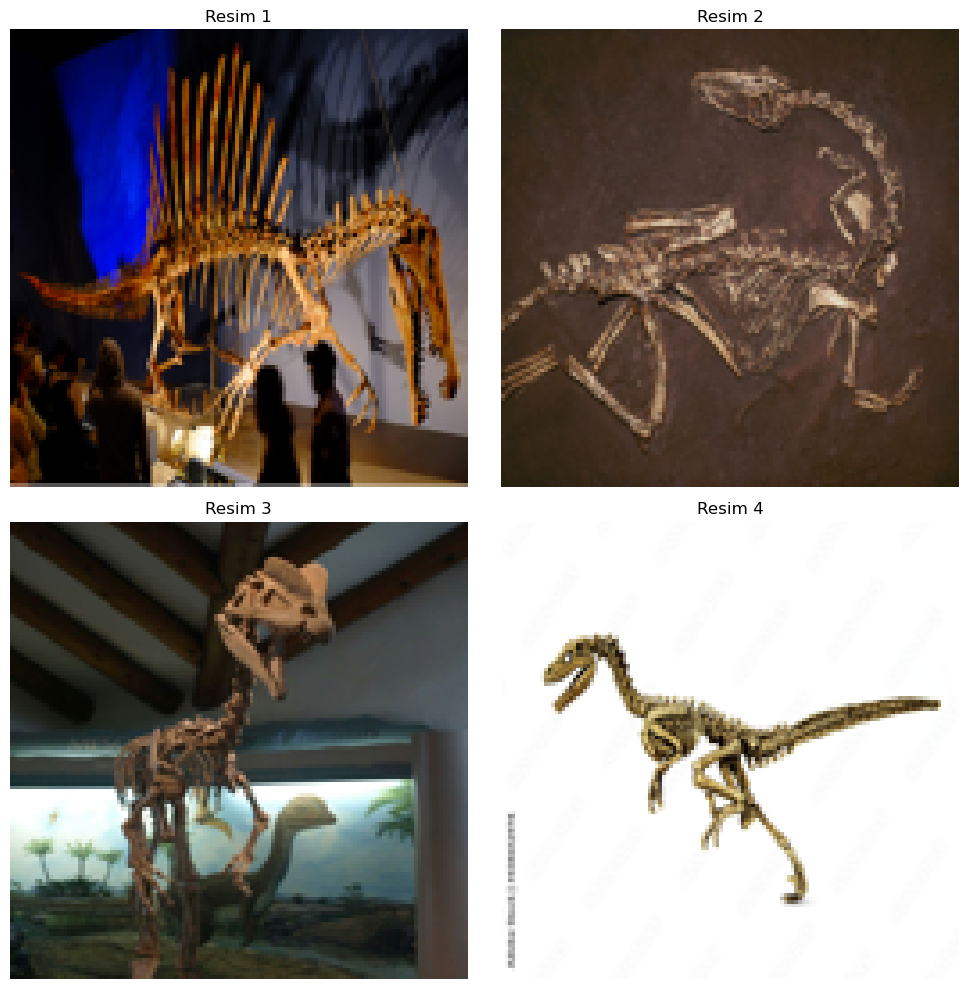

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) 
axs = axs.ravel()  

for i in range(4): 
    axs[i].imshow(data[i])
    axs[i].set_title(f"Resim {i+1}")
    axs[i].axis('off')  

plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='reflect',
)

In [59]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize

X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)


def resize_images(images, new_size=(512, 512)):
    resized_images = np.array([resize(image, new_size, anti_aliasing=True) for image in images])
    return resized_images


X_train_resized = resize_images(X_train)*255
X_val_resized = resize_images(X_val)*255
X_test_resized = resize_images(X_test)*255


train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,  
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2,  
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True, 
    brightness_range=[0.5, 1.5],
    fill_mode='reflect'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=8)
val_generator = test_val_datagen.flow(X_val_resized, y_val, batch_size=8)
test_generator = test_val_datagen.flow(X_test_resized, y_test, batch_size=8)


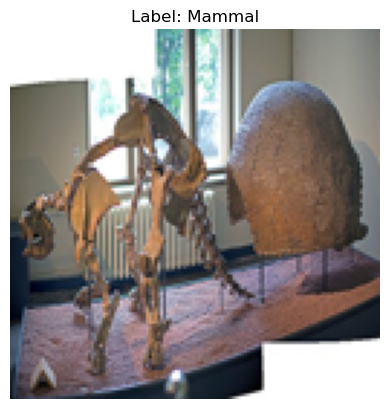

In [45]:
def show_image_with_label(index, X_train, y_train):
    plt.imshow(X_train[index])
    plt.title(f"Label: {'Dinosaur' if y_train[index] == 1 else 'Mammal'}")
    plt.axis('off')
    plt.show()


show_image_with_label(88, X_train, y_train)

In [46]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:", class_distribution)

Class Distribution: {0: 120, 1: 83}


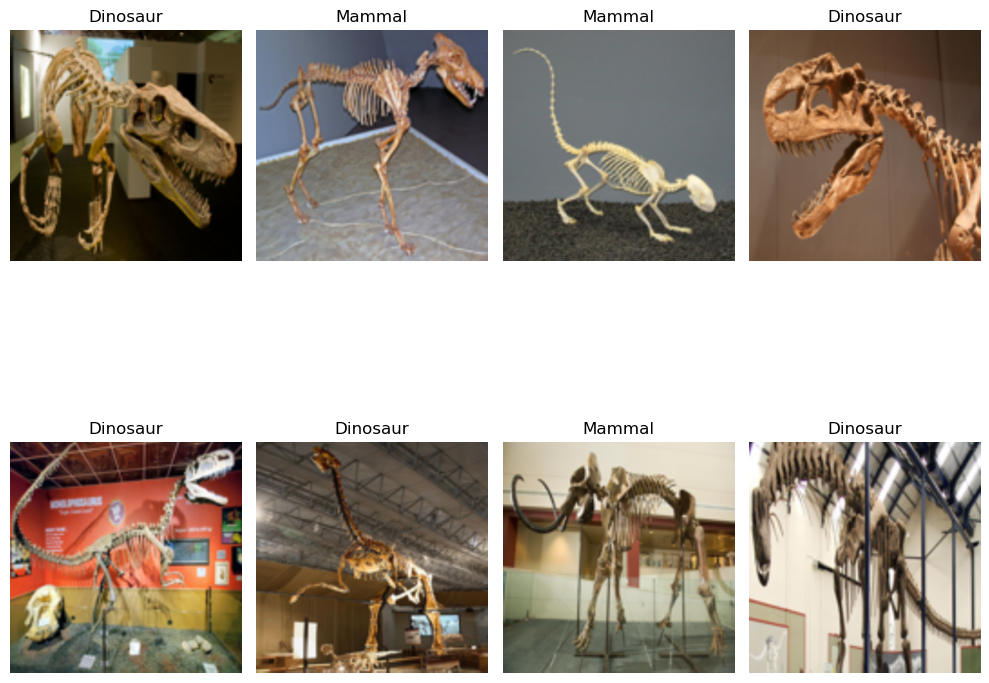

In [47]:
import matplotlib.pyplot as plt

def show_images_from_generator(generator, class_labels, num_images=8):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[int(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
class_labels = ['Mammal', 'Dinosaur']
show_images_from_generator(val_generator, class_labels)


### MODEL

In [48]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

MAX_SIDE_LEN = 512

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True 
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [49]:
# Model eğitimi
history = model.fit(
    train_generator,
    epochs=60,
    batch_size=16,
    validation_data=val_generator,
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 859ms/step - accuracy: 0.6201 - loss: 0.7888 - val_accuracy: 0.5909 - val_loss: 0.6744
Epoch 2/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 834ms/step - accuracy: 0.5486 - loss: 0.6837 - val_accuracy: 0.5455 - val_loss: 0.7058
Epoch 3/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 877ms/step - accuracy: 0.6311 - loss: 0.6652 - val_accuracy: 0.7045 - val_loss: 0.6346
Epoch 4/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.7150 - loss: 0.5992 - val_accuracy: 0.7045 - val_loss: 0.6465
Epoch 5/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 796ms/step - accuracy: 0.6930 - loss: 0.6177 - val_accuracy: 0.6818 - val_loss: 0.6608
Epoch 6/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 804ms/step - accuracy: 0.5636 - loss: 0.6848 - val_accuracy: 0.7045 - val_loss: 0.6544
Epoch 7/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 806ms/step - accuracy: 0.7106 - loss: 0.6064 - val_accuracy: 0.6818 - val_loss: 0.6252
Epoch 8/60
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 838ms/step - accuracy: 0.6671 - loss: 0.6314 - val_accu

In [50]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test seti üzerindeki kayıp: {test_loss}, Accuracy: {test_acc}")

6/6 - 1s - 128ms/step - accuracy: 0.6364 - loss: 0.6320
Test seti üzerindeki kayıp: 0.6320217251777649, Accuracy: 0.6363636255264282


In [63]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = y_test
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Mammal', 'Dinosaur']))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
Classification Report:
              precision    recall  f1-score   support

      Mammal       0.38      0.42      0.40        19
    Dinosaur       0.52      0.48      0.50        25

    accuracy                           0.45        44
   macro avg       0.45      0.45      0.45        44
weighted avg       0.46      0.45      0.46        44

Confusion Matrix:
[[ 8 11]
 [13 12]]


In [53]:
from tensorflow.keras.preprocessing import image


img_path = r'C:\Users\Van_P\OneDrive\Masaüstü\Projects\Deep Learning\İmage_process\Dinosaur_Project/deneme5.jpg'
img = image.load_img(img_path, target_size=(512, 512))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


predictions = model.predict(img_array)

class_names = ['Mammal', 'Dinosaur'] 
threshold = 0.5
predicted_class = class_names[int(predictions > threshold)]

print(f"Model, It is a {predicted_class}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Model, It is a Mammal.


C:\Users\Van_P\AppData\Local\Temp\ipykernel_32636\2261403406.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(predictions > threshold)]
